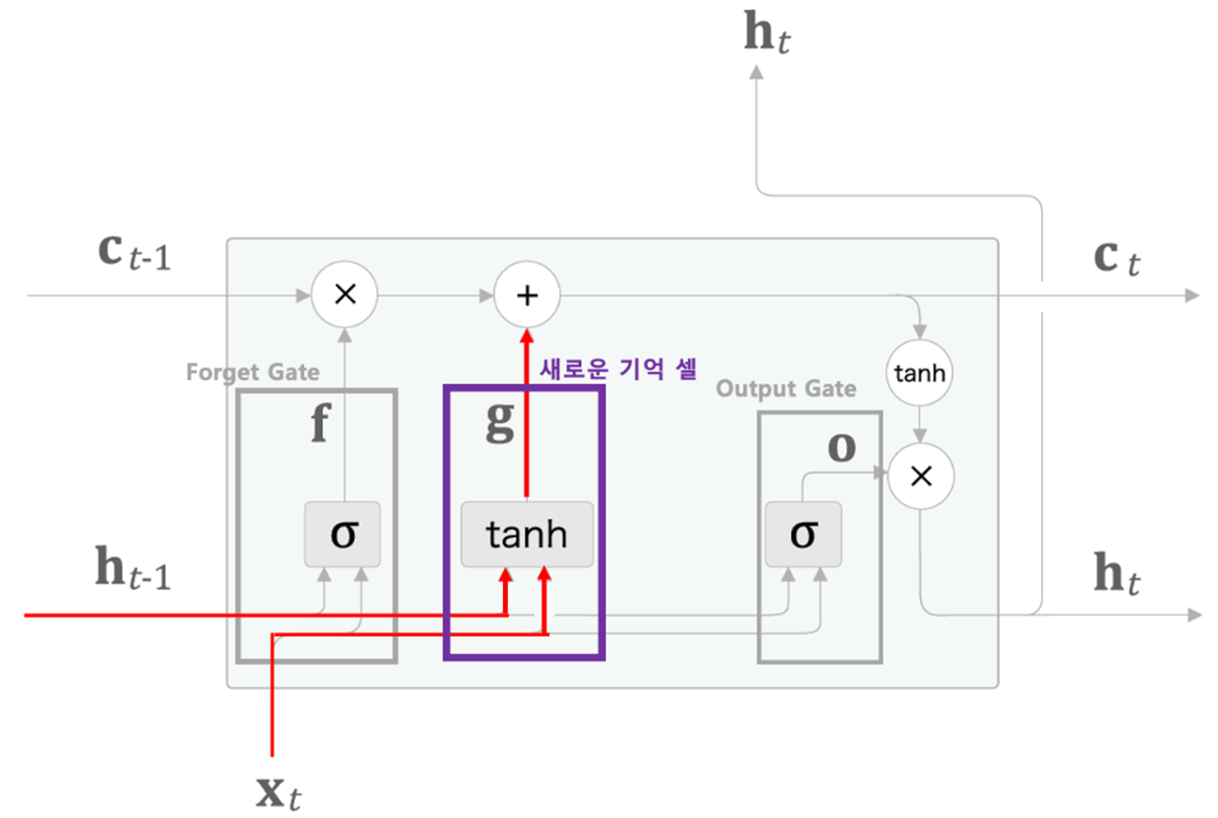
- forget gate(f) : 이전 시각 기억 셀 c를 잊기 (sigmoid;0~1 얼만큼 통과할지)
- new memory cell(g) : 이전 기억 기억 셀 c에 tanh으로 제어(인코딩된 정보 강약 제어 -1~1)하고 추가
- output gate(o) : 은닉 상태 출력 담당
- input gate(i) : g가 얼마나 가치가 큰지 판단

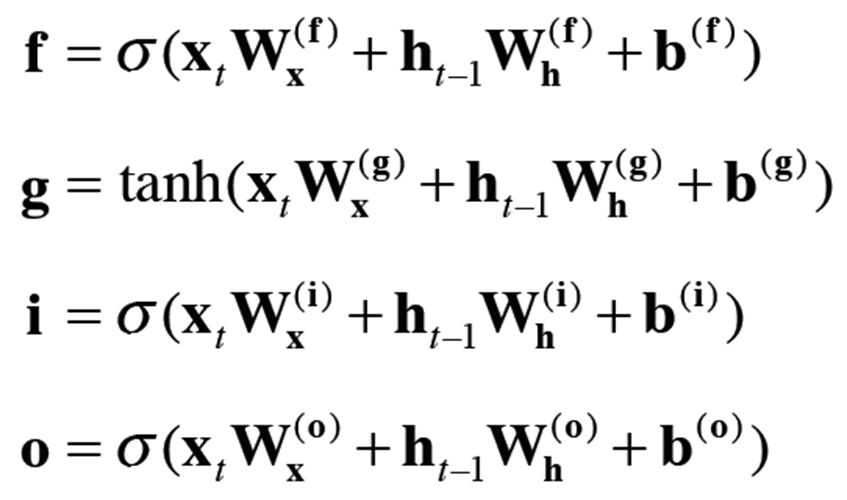 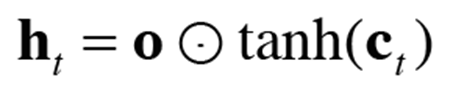 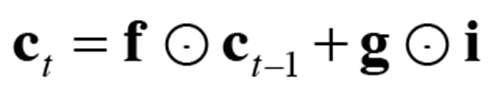

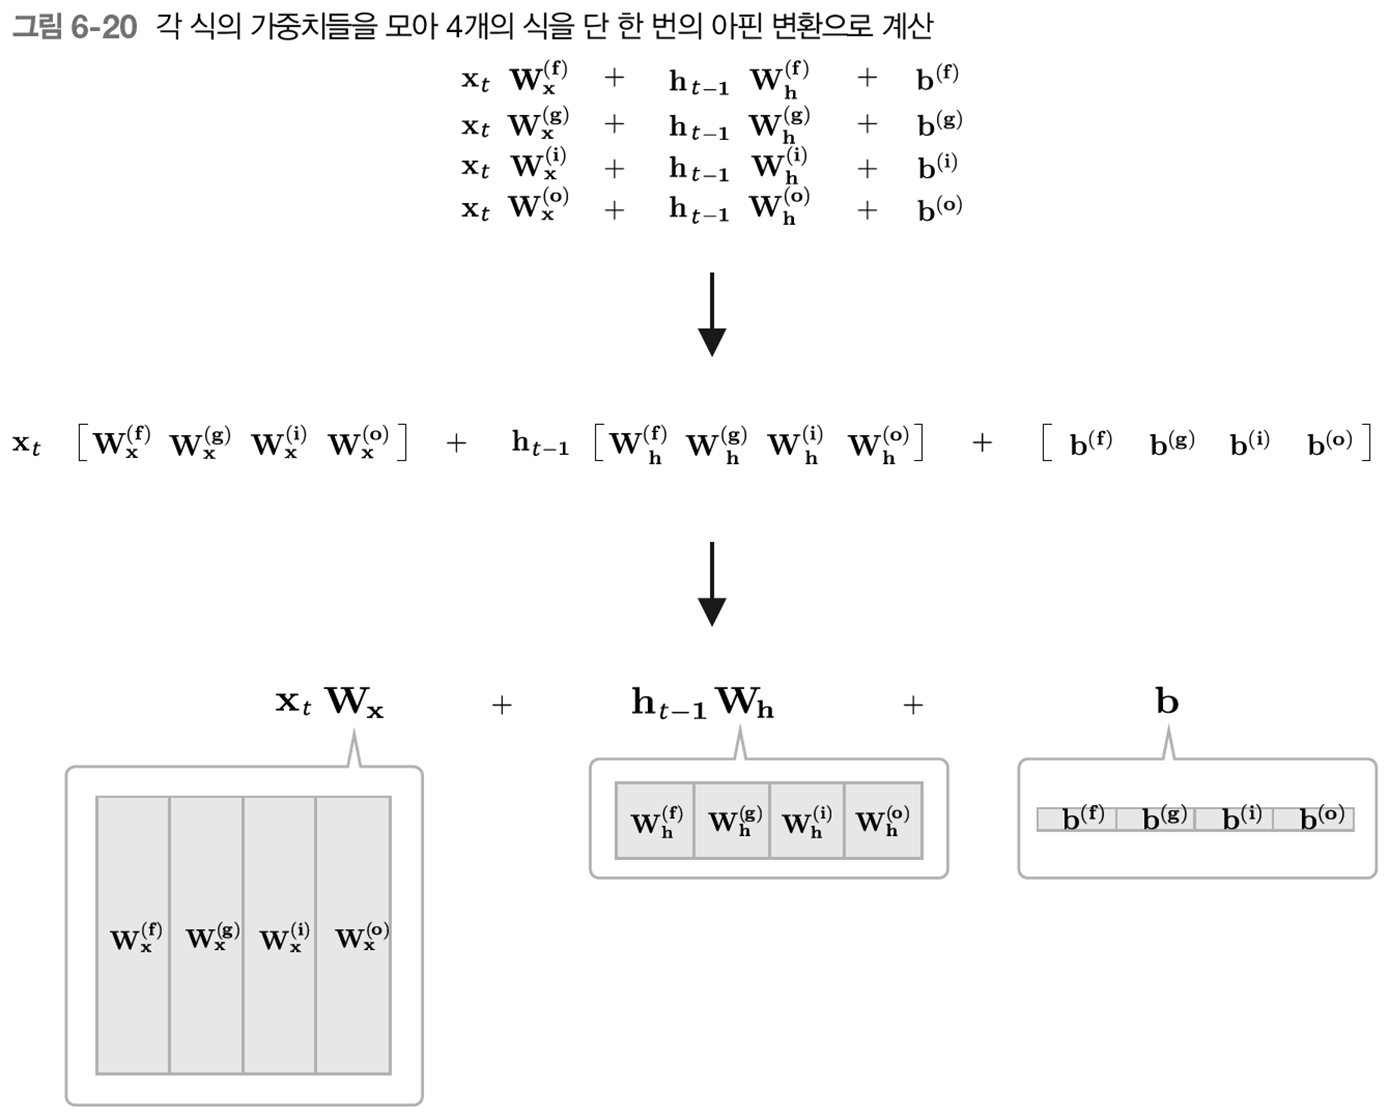

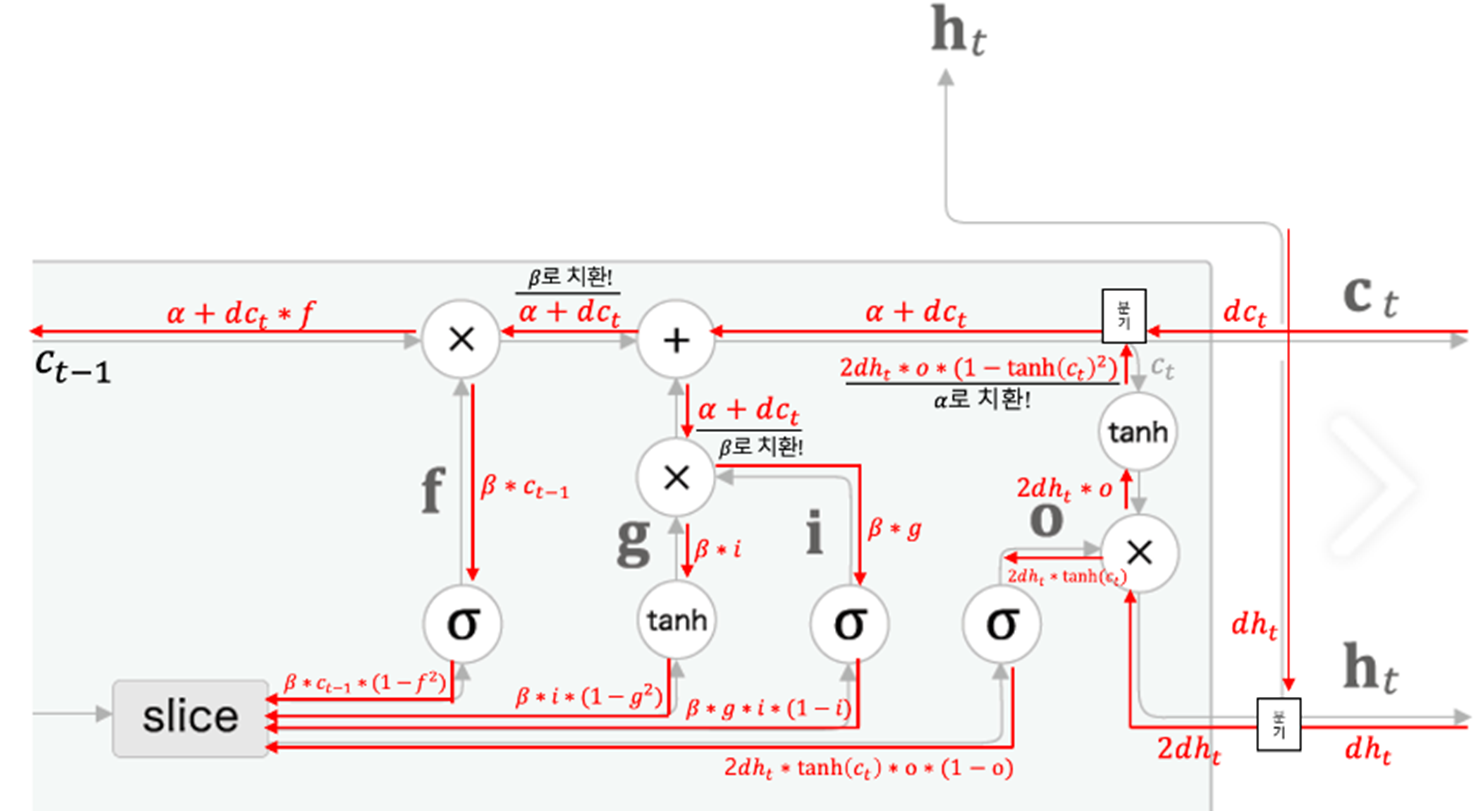

In [1]:
import sys
sys.path.append('..')
from common.functions import *

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 모두 0으로!
        self.cache = None # 역전파 계산에 사용

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        # 1. Affine Transformation (한번에 계산해버림, 어차피 가중치 똑같이 공유유)
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b # 기존rnn(hidden)

        # 2. 4 Slice (3 gates & 1 memorycell)
        f = A[:, :H]
        g = A[: H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f) # 0~1 얼만큼 통과?
        g = np.tanh(g) # -1~1 강도
        i = sigmoid(i)
        o = sigmoid(o)

        # 3. 출력
        c_next = f * c_prev + g*i # 전꺼를 얼만큼 잊을지(sigmoid) + 들어온 값을 얼만큼 반영할지(tanh)
        h_next = o * np.tanh(c_next) # 기존 rnn(hidden) 계산 * 기억cell 을 얼만큼 반영해서(tanh)

        self.cache = (x, h_prev, h_next, i, f, g, o, c_next)
        
        return h_next, c_next
    
    def backward(self, dh_next, dc_next): # (N * 4H)를 slice한걸 결합해야 함 >> 가로로 연결 np.hstack((df, dg, di, do))
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        # 1. cell state가 tanh 통과
        tanh_c_next = np.tanh(c_next)
        # 2. 위에서 흘러옴
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev